In [1]:
#import from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
!pip install joblib
import joblib

## 1. Data Pre-processing

The dataset is the Steam 200k Video Games Dataset taken from [Kaggle](https://www.kaggle.com/datasets/tamber/steam-video-games).

In [3]:
#import steam 200k dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/steam/steam-200k.csv', names=['user_id','game','behaviour','value','other'])

#convert user_id to string
df['user_id'] = df['user_id'].astype(str)

In [4]:
df.head()

,user_id,game,behaviour,value,other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


This dataset is a list of user behaviors, with columns: user_id, game, behaviour, value. The behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.

The 'other' column is dropped as it does not provide any meaning to the data to ensure that only relevant information is retained

In [5]:
#dropping irrelevant columns
df = df.drop('other', axis=1)
df.head()

,user_id,game,behaviour,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [6]:
#checking for missing values
df.isna().any()

user_id      False
game         False
behaviour    False
value        False
dtype: bool

There are surprisingly no missing values in the dataset

## 2. Exploratory Data Analysis

In [7]:
#dataframe with playtime data
play_df = df[df['behaviour']=='play'].rename(columns={'value': 'hours_played'}).drop('behaviour',axis=1)
play_df.head()

,user_id,game,hours_played
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


We've created a separate dataframe for the playtime data which we will use for further analysis of users and the games they play.

In [8]:
print("Number of games: ", len(play_df['game'].unique()))
print("Number of users: ", len(play_df['user_id'].unique()))

Number of games:  3600
Number of users:  11350


There are 3600 games in total and 11350 users

In [9]:
#descriptive stats for playtime data
play_df.describe()

,hours_played
count,70489.000000
mean,48.878063
std,229.335236
min,0.100000
25%,1.000000
50%,4.500000
75%,19.100000
max,11754.000000


The playtime data for Steam users shows a highly skewed distribution, with a median of 4.5 hours and a mean of 48.88 hours, indicating that most users have low engagement while a few have extremely high playtime. The maximum playtime recorded is 11,754 hours, highlighting the presence of highly dedicated gamers.

### 2.1. Distribution of user behaviour

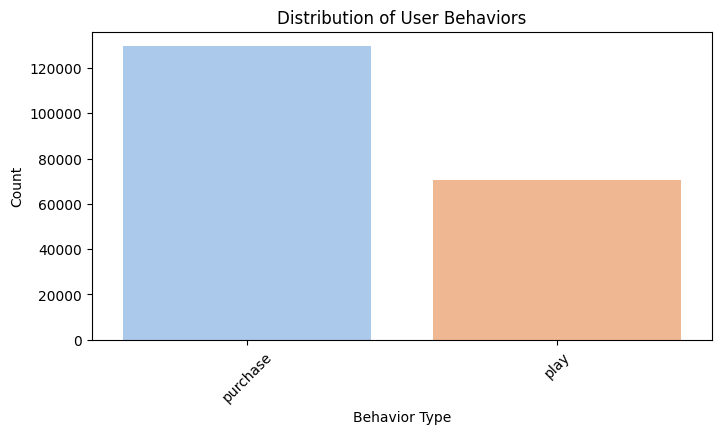

In [10]:
#distribution of user behaviors - purchase & play
behavior_counts = df['behaviour'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=behavior_counts.index, y=behavior_counts.values, hue=behavior_counts.index, palette="pastel")
plt.title('Distribution of User Behaviors')
plt.xlabel('Behavior Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

This barplot was visualised to analyse the distribution of behaviours between users. It can be seen that purchases are more frequent than play activities. Specifically, there are over 120k purchase events compared to around 80k play events, indicating that users engage in purchasing games more frequently than playing them.

### 2.2. Distribution of playtime

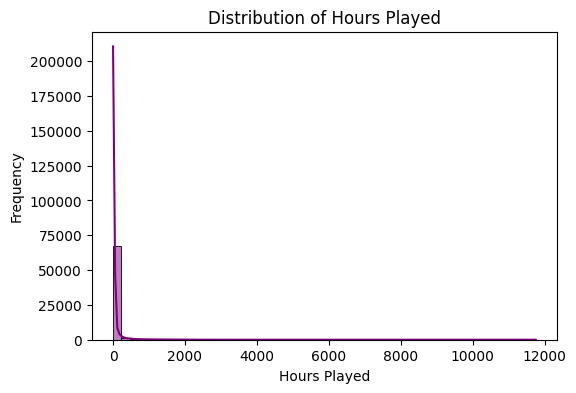

In [11]:
#distribution of playtime values
plt.figure(figsize=(6, 4))
sns.histplot(play_df['hours_played'], bins=50, kde=True, color='purple')
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()


The distribution of playtime was analyzed to understand the spread and central tendency of hours played by users. It can be seen that the tail is heavily skewed on the right and makes it difficult to analyse. Performing a log-transformation or zooming in on the data might provide more insights.

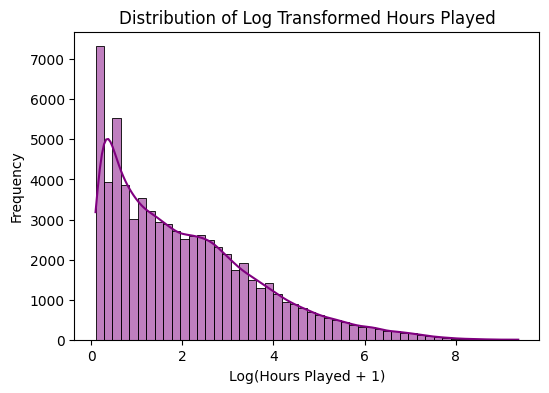

In [12]:
#distribution of playtime values with log transformation
play_df['log_value'] = np.log1p(play_df['hours_played'])

plt.figure(figsize=(6, 4))
sns.histplot(play_df['log_value'], bins=50, kde=True, color='purple')
plt.title('Distribution of Log Transformed Hours Played')
plt.xlabel('Log(Hours Played + 1)')
plt.ylabel('Frequency')
plt.show()


The log-transformed histogram provided a more normalized view, highlighting the presence of many users with relatively low playtime.

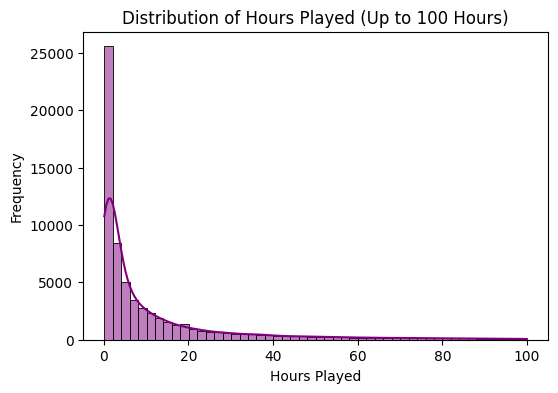

In [13]:
#distribution of playtime values (zoomed in up to 100 hours)
plt.figure(figsize=(6, 4))
sns.histplot(play_df[play_df['hours_played'] <= 100]['hours_played'], bins=50, color = 'purple', kde=True)
plt.title('Distribution of Hours Played (Up to 100 Hours)')
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.show()

Focusing on playtime up to 100 hours, the histogram indicated that a significant portion of users fall within this range, reinforcing the skewness observed in the overall distribution.


## 3. User and Game Analysis

### 3.1 Most Played Games

In [14]:
#top 10 games by playtime
top_games = play_df.groupby('game')['hours_played'].sum().nlargest(10).reset_index()

fig = px.bar(top_games, x='hours_played', y='game', orientation='h', title='Top 10 Games by Total Playtime',
             labels={'hours_played': 'Total Playtime (hours)', 'game': 'Game Title'}, color = 'hours_played')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


Identifying the most played games helps in understanding game popularity and user preferences. The bar plot displays the top 10 games on Steam by total playtime. "Dota 2" leads with the highest playtime, followed by "Counter-Strike: Global Offensive" and "Team Fortress 2". The visual highlights that a small number of games account for the majority of total playtime, indicating their popularity and significant user engagement.

### 3.2. Playtime per User

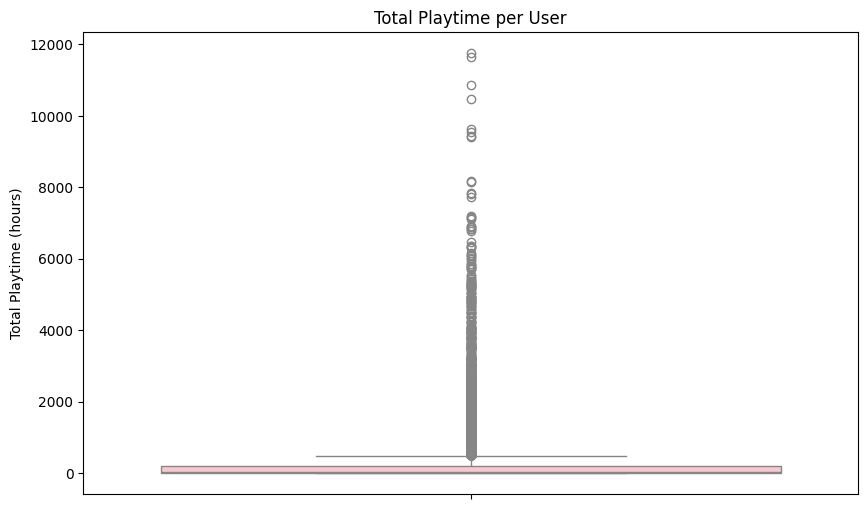

In [15]:
#total playtime per user
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(y='hours_played', data=user_playtime, color='pink')
plt.title('Total Playtime per User')
plt.ylabel('Total Playtime (hours)')
plt.show()


Analysing playtime per user provides insights into individual engagement levels.  The box plot of total playtime per user illustrates the overall distribution, highlighting the presence of significant outliers. While the majority of users have relatively low playtime, the plot shows a median playtime that is quite low, with most data points concentrated at the bottom. The whiskers extend slightly beyond the lower range, but there is a notable number of outliers extending up to nearly 12,000 hours, indicating a small group of users with exceptionally high playtime. This extreme variance underscores the diverse engagement levels within the user base, with a few highly dedicated gamers standing out.

Let's zoom in on the bottom range to uncover more insights

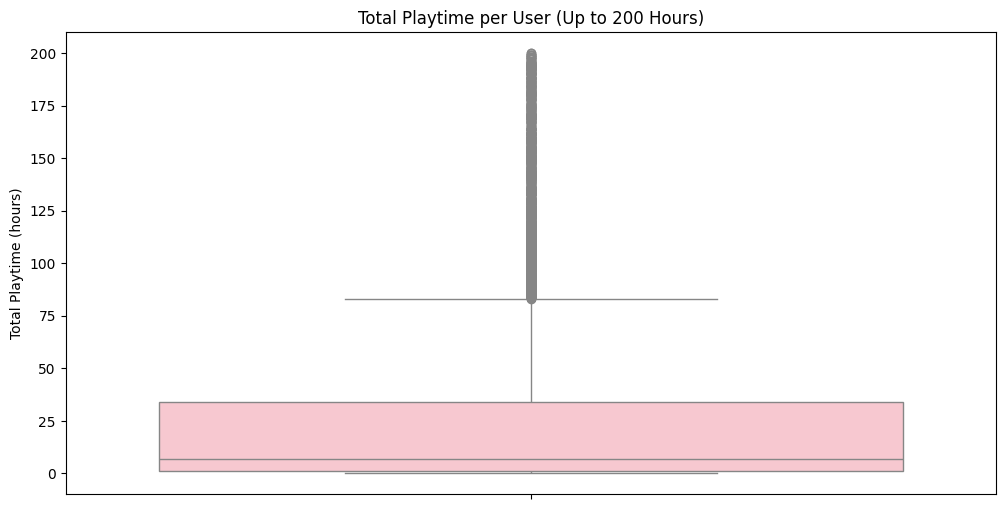

In [16]:
#total playtime per user (zoomed in)
plt.figure(figsize=(12, 6))
sns.boxplot(y='hours_played', data=user_playtime[user_playtime['hours_played'] <= 200], color='pink')
plt.title('Total Playtime per User (Up to 200 Hours)')
plt.ylabel('Total Playtime (hours)')
plt.show()

The box plot shows the total playtime per user, focusing on users with up to 200 hours of playtime. Most users have total playtimes between 0 and 50 hours, with a median playtime of around 25 hours. The presence of numerous outliers above 75 hours indicates a significant number of users with higher playtimes, but the majority remain below this threshold. This plot provides a clear view of typical user engagement while highlighting those with more substantial playtime within the specified range.

### 3.2 User Segmentation - Clustering Users Based on Playtime

In [17]:
#standardising the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(play_df[['hours_played']])

#applying KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
play_df['cluster'] = kmeans.fit_predict(scaled_features)

#visualising the clusters
fig = px.scatter(play_df, x='user_id', y='hours_played', color='cluster',
                 title='Clusters of Users Based on Playtime',
                 labels={'user_id': 'User ID', 'hours_played': 'Hours Played'})

#update color scale
fig.update_traces(marker=dict(coloraxis="coloraxis"))
fig.update_layout(coloraxis=dict(
    colorbar=dict(
        tickvals=[0, 1, 2, 3],
        ticktext=['0', '1', '2', '3']
    )
))

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



The plot clearly demonstrates the segmentation of users into distinct groups based on their gaming behavior, with most users falling into the lower playtime clusters and a few in the high playtime clusters. This segmentation can be useful for targeted marketing and personalized recommendations based on user engagement.

- Cluster 0:  This cluster contains users with the lowest playtime, indicating casual or infrequent gamers.
- Cluster 1: Users in this cluster have moderate playtime, suggesting a balanced engagement with games.
- Cluster 2: This cluster represents users with higher playtime, indicating more dedicated gamers.
- Cluster 3: Users in this cluster have playtime roughly between 1,000 to 4,000 hours, indicating highly engaged gamers.
- Cluster 4: This cluster represents the users with the highest playtime, ranging from almost 4,000 hours up to nearly 12,000 hours, highlighting a small group of extremely dedicated or hardcore gamers.



## 4. Correlation and Feature Analysis

### 4.1. Playtime vs. Number of Games Played

In [18]:
#playtime vs. number of games played
user_game_count = play_df.groupby('user_id')['game'].nunique().reset_index()
user_game_count.columns = ['user_id', 'num_games']
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()
user_playtime.columns = ['user_id', 'total_playtime']
merged_df = pd.merge(user_game_count, user_playtime, on='user_id')

fig = px.scatter(merged_df, x='num_games', y='total_playtime', title='Playtime vs. Number of Games Played',
                 labels={'num_games': 'Number of Games Played', 'total_playtime': 'Total Playtime (hours)'},
                 color='total_playtime')
fig.show()

- There is a noticeable positive correlation between the number of games played and the total playtime indicatiing users who play more games tend to have higher total playtime.
- The majority of users have played fewer than 100 games, with playtime mostly concentrated below 2,000 hours. However, there are significant outliers with higher playtime and a larger number of games played.
- A few users have extremely high total playtime (up to 12,000 hours), often associated with playing a large number of games.

Overall, the plot illustrates that while most users have a moderate number of games and playtime, a small subset of highly dedicated gamers plays a large number of games for extended hours.

Understanding the relationship between playtime and the number of games played helps in identifying how diverse gaming habits impact total playtime.

### 4.2 Playtime vs Number of Purchases

In [19]:
#purchase vs. play correlation
purchase_df = df[df['behaviour'] == 'purchase']
purchase_count = purchase_df.groupby('user_id')['value'].count().reset_index()
purchase_count.columns = ['user_id', 'num_purchases']
merged_df = pd.merge(purchase_count, user_playtime, on='user_id')

fig = px.scatter(merged_df, x='num_purchases', y='total_playtime', title='Purchase vs. Play Correlation',
                 labels={'num_purchases': 'Number of Purchases', 'total_playtime': 'Total Playtime (hours)'},
                 color='total_playtime')
fig.show()


- Most users have made fewer than 100 purchases, with their total playtime mostly concentrated below 2,000 hours. However, there are significant outliers with higher total playtime and a larger number of purchases.
- A few users have extremely high total playtime often associated with a higher number of purchases (outliers)
- Users with over 400 purchases generally have high total playtime, indicating that high purchasing behavior correlates strongly with high engagement.

Overall, the plot illustrates that while most users have a moderate number of purchases and playtime, a small subset of users exhibits both high purchasing and high playtime behavior, emphasizing a significant relationship between purchasing games and the amount of time spent playing them.

## 5. Feature Engineering

In [20]:
#calculate number of games played by each user
user_game_count = play_df.groupby('user_id')['game'].nunique().reset_index()
user_game_count.columns = ['user_id', 'num_games']

#calculate total playtime for each user
user_playtime = play_df.groupby('user_id')['hours_played'].sum().reset_index()
user_playtime.columns = ['user_id', 'total_playtime']

#filter purchase data
purchase_df = df[df['behaviour'] == 'purchase'].rename(columns={'value': 'purchases'}).drop('behaviour', axis=1)

#calculate the number of purchases by each user
purchase_count = purchase_df.groupby('user_id')['purchases'].count().reset_index()
purchase_count.columns = ['user_id', 'num_purchases']

#merge all features into a single df
merged_df = user_game_count.merge(user_playtime, on='user_id').merge(purchase_count, on='user_id', how='left')

#fill any NaN values resulting from the merge
merged_df['num_purchases'].fillna(0, inplace=True)

#create additional features
merged_df['avg_playtime_per_game'] = merged_df['total_playtime'] / merged_df['num_games']
merged_df['purchase_playtime_ratio'] = merged_df['total_playtime'] / merged_df['num_purchases']
merged_df['avg_playtime_per_game'].fillna(0, inplace=True)
merged_df['purchase_playtime_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
merged_df['purchase_playtime_ratio'].fillna(0, inplace=True)

#prepare features and target
features = merged_df.drop(columns=['user_id', 'total_playtime'])
target = merged_df['total_playtime']

print(features.head())
print(target.head())

   num_games  num_purchases  avg_playtime_per_game  purchase_playtime_ratio
0          1              1               0.700000                 0.700000
1          6              7               6.100000                 5.228571
2          4              5              10.825000                 8.660000
3          4              7              70.750000                40.428571
4         21             38              33.628571                18.584211
0      0.7
1     36.6
2     43.3
3    283.0
4    706.2
Name: total_playtime, dtype: float64


- num_games: The number of unique games played by each user. Users who play many different games might have different engagement patterns compared to those who play only a few games extensively.
- num_purchases: The number of purchases made by each user. More purchases often imply greater engagement and a willingness to explore new content, which can lead to higher total playtime.
- avg_playtime_per_game: The average playtime per game for each user. Users with a high average playtime per game are likely deeply engaged with the games they play, suggesting a different behavior pattern compared to those who play many games for shorter periods.
- purchase_playtime_ratio: The ratio of total playtime to the number of purchases for each user. Users with a high purchase playtime ratio might be very selective in their purchases and play each game extensively, whereas those with a low ratio might purchase many games but not play them much.

The selected features provide a well-rounded representation of user behavior on Steam, covering the variety of games played, number of purchases, and how intensely users engage with their games. These features are effective for predicting total playtime because they capture important aspects of user activity.

### 5.1 User Segmentation Analysis based on added features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



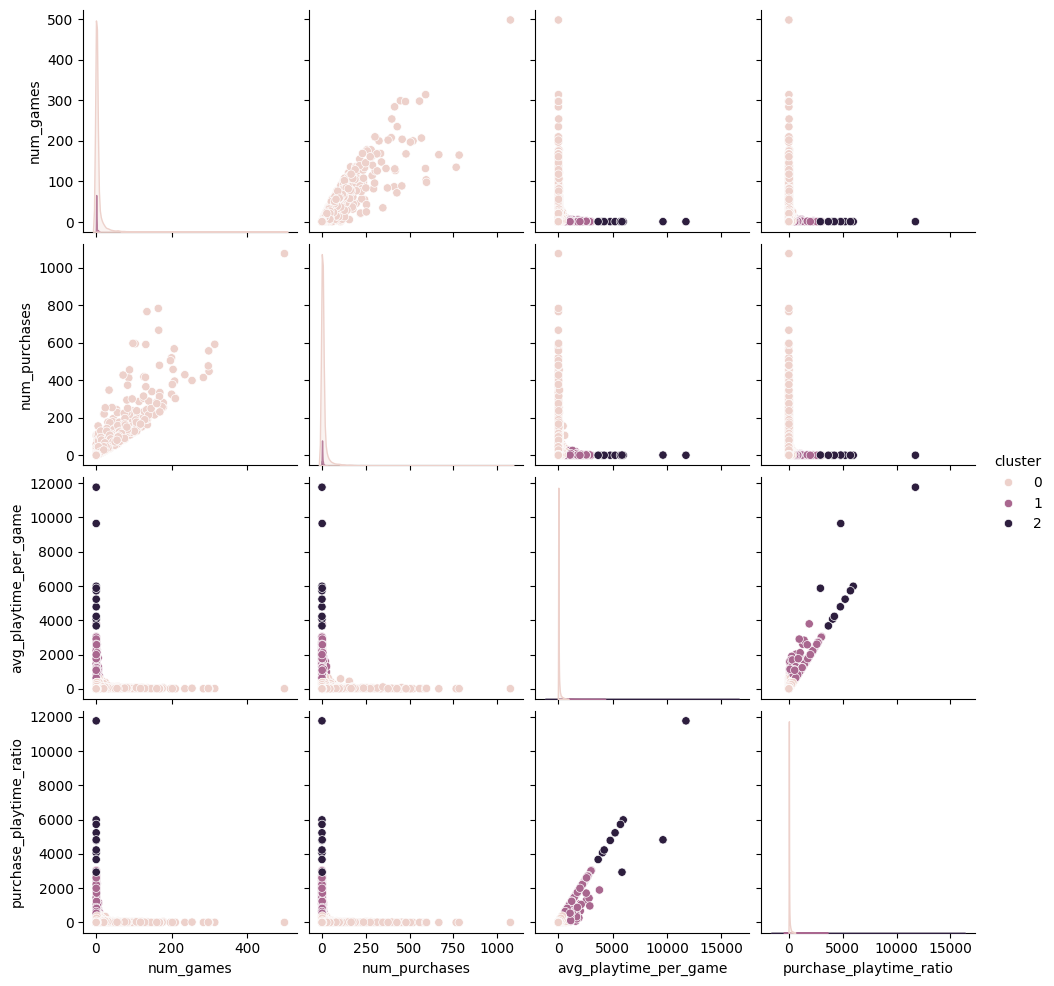

In [21]:
#clustering features
clustering_features = features[['num_games', 'num_purchases', 'avg_playtime_per_game', 'purchase_playtime_ratio']]

#perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_features)

#add cluster labels to the original df
merged_df['cluster'] = clusters

#visualise the clusters
sns.pairplot(merged_df, hue='cluster', vars=['num_games', 'num_purchases', 'avg_playtime_per_game', 'purchase_playtime_ratio'])
plt.show()


- Cluster 0: Users with the lowest playtime and the fewest games played, purchases made, and lowest average playtime per game.
- Cluster 1: Users with moderate playtime, a moderate number of games played, purchases made, and average playtime per game.
- Cluster 2: Users with the highest playtime, the most games played, the highest number of purchases, and the highest average playtime per game.

- num_games vs. num_purchases: There is a positive correlation, indicating that users who play more games tend to make more purchases.
- avg_playtime_per_game vs. purchase_playtime_ratio: Both clusters show a spread indicating different playtime behaviors. Cluster 2 stands out with significantly higher values.
- avg_playtime_per_game vs. num_games: Shows that users with higher average playtime per game tend to have played fewer games.

The clustering effectively segments users into distinct groups based on their playtime and gaming behavior. High playtime users (Cluster 2) exhibit unique characteristics such as high average playtime per game and a higher number of purchases. There is a clear distinction in the feature distributions between the clusters, highlighting the variability in user behavior on Steam.

## 6. Dataset Split

The dataset is split into 80-20 ratio for training and test sets.

In [22]:
#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 7. Model Training

### 7.1. Linear Regression

Processing fold 1/10 for Linear Regression...
Fold 1 score: 0.49714505515166085
Processing fold 2/10 for Linear Regression...
Fold 2 score: 0.5158316277926471
Processing fold 3/10 for Linear Regression...
Fold 3 score: 0.5079313157526254
Processing fold 4/10 for Linear Regression...
Fold 4 score: 0.593494274323922
Processing fold 5/10 for Linear Regression...
Fold 5 score: 0.571289367875128
Processing fold 6/10 for Linear Regression...
Fold 6 score: 0.475296550188426
Processing fold 7/10 for Linear Regression...
Fold 7 score: 0.6093131341217769
Processing fold 8/10 for Linear Regression...
Fold 8 score: 0.5981878823963037
Processing fold 9/10 for Linear Regression...
Fold 9 score: 0.533112487005061
Processing fold 10/10 for Linear Regression...
Fold 10 score: 0.5180447161928478
Linear Regression Cross-validation scores: [0.49714505515166085, 0.5158316277926471, 0.5079313157526254, 0.593494274323922, 0.571289367875128, 0.475296550188426, 0.6093131341217769, 0.5981878823963037, 0.5331124

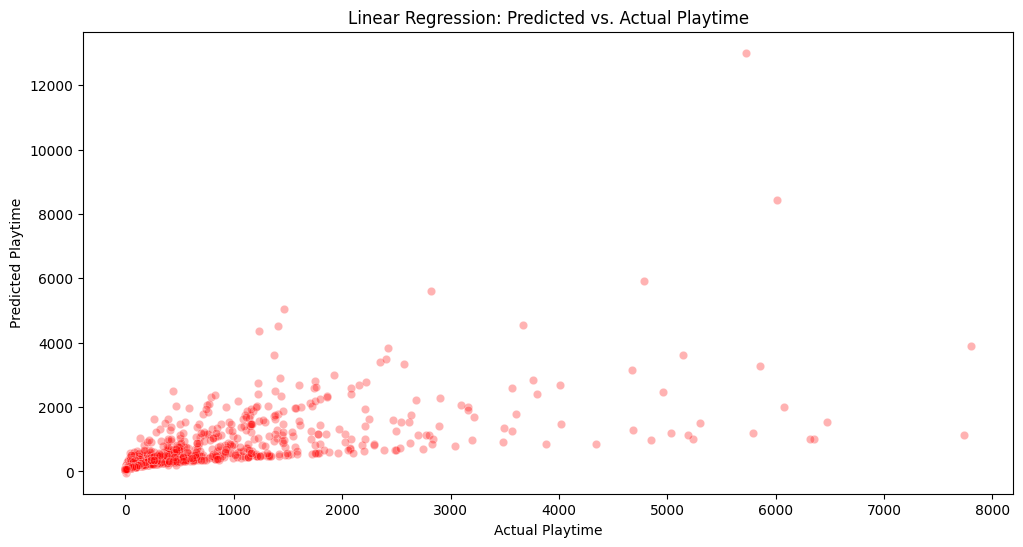

In [23]:
#define cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

#train model and perform cross-validation
lr_model = LinearRegression()
cv_scores_lr = []
for fold, (train_idx, val_idx) in enumerate(kf.split(features, target)):
    print(f"Processing fold {fold + 1}/{kf.get_n_splits()} for Linear Regression...")
    lr_model.fit(features.iloc[train_idx], target.iloc[train_idx])
    score = lr_model.score(features.iloc[val_idx], target.iloc[val_idx])
    cv_scores_lr.append(score)
    print(f"Fold {fold + 1} score: {score}")

print(f"Linear Regression Cross-validation scores: {cv_scores_lr}")
print(f"Linear Regression Mean CV score: {np.mean(cv_scores_lr)}")

#train the model on the entire training set
lr_model.fit(X_train, y_train)

#save the model
joblib.dump(lr_model, 'linear_regression_model.joblib')

#make predictions
y_pred_lr = lr_model.predict(X_test)

#evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression R^2: {r2_lr}")

#plot predicted vs. actual playtime for Linear Regression
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3, color='red')
plt.title('Linear Regression: Predicted vs. Actual Playtime')
plt.xlabel('Actual Playtime')
plt.ylabel('Predicted Playtime')
plt.show()

Using Linear Regression as a baseline model, the total playtime was predicted.
- The model tends to underestimate playtime for users with higher actual playtime values. This is evident from the points where the actual playtime is much higher than the predicted playtime.
- Most data points are clustered at lower playtime values, both actual and predicted, indicating that the model performs better for users with lower total playtime.
- The spread of points, especially for higher actual playtime, suggests that the linear regression model struggles to accurately predict extreme values, indicating potential limitations in capturing complex relationships within the data.

Overall, while the linear regression model provides some predictive capability, it lacks accuracy for users with very high playtime, highlighting the need for more sophisticated models to improve prediction performance.

Let's try to imrpove this with Random Forest & XGBoost models

### 7.2. Random Forest Regressor

Processing fold 1/10 for Random Forest...
Fold 1 score: 0.9749914272559785
Processing fold 2/10 for Random Forest...
Fold 2 score: 0.9634498330694847
Processing fold 3/10 for Random Forest...
Fold 3 score: 0.9596432448234551
Processing fold 4/10 for Random Forest...
Fold 4 score: 0.970746680735341
Processing fold 5/10 for Random Forest...
Fold 5 score: 0.9179705417004738
Processing fold 6/10 for Random Forest...
Fold 6 score: 0.9649285800355251
Processing fold 7/10 for Random Forest...
Fold 7 score: 0.970331643772001
Processing fold 8/10 for Random Forest...
Fold 8 score: 0.9569847954853098
Processing fold 9/10 for Random Forest...
Fold 9 score: 0.9795558850273091
Processing fold 10/10 for Random Forest...
Fold 10 score: 0.9768164035347001
Random Forest Cross-validation scores: [0.9749914272559785, 0.9634498330694847, 0.9596432448234551, 0.970746680735341, 0.9179705417004738, 0.9649285800355251, 0.970331643772001, 0.9569847954853098, 0.9795558850273091, 0.9768164035347001]
Random Fores

<ipython-input-24-950e24cfa3c8>:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




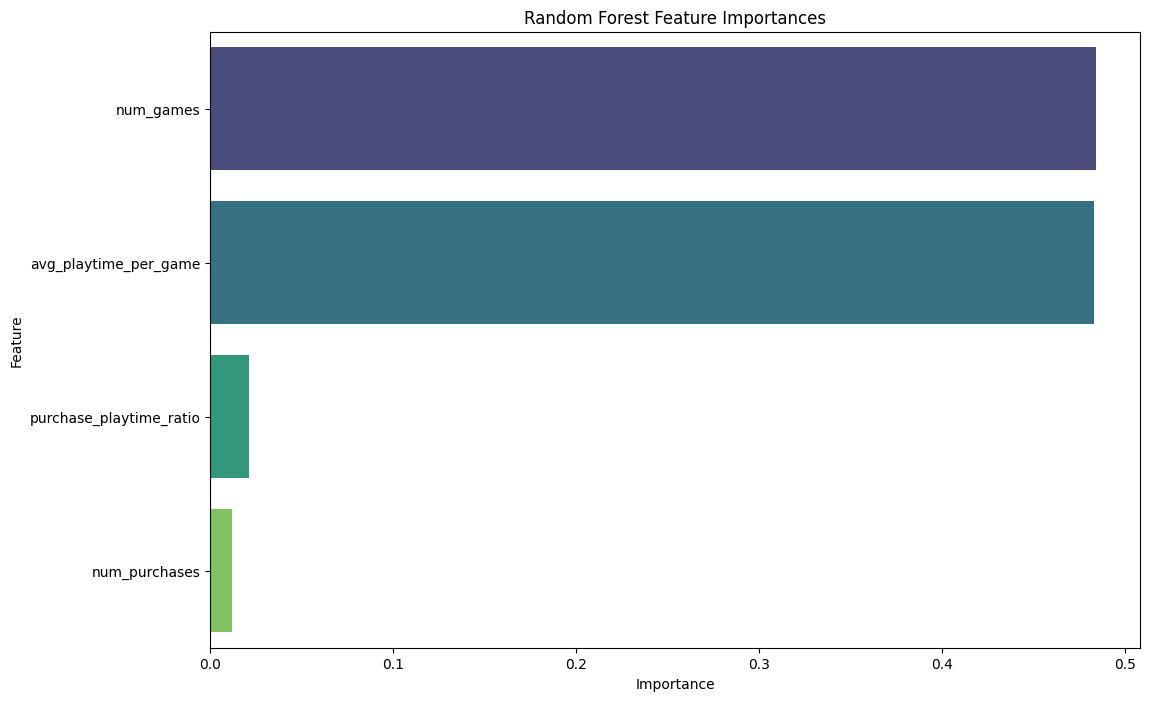

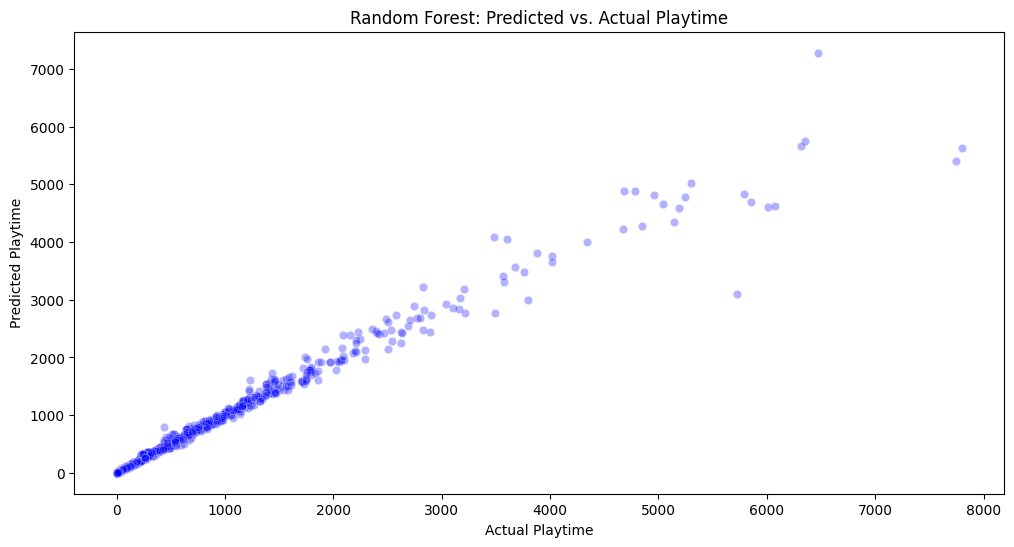

In [24]:
#train model and perform cross-validation
cv_scores_rf = []
rf_model = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(features, target)):
    print(f"Processing fold {fold + 1}/{kf.get_n_splits()} for Random Forest...")
    rf_model.fit(features.iloc[train_idx], target.iloc[train_idx])
    score = rf_model.score(features.iloc[val_idx], target.iloc[val_idx])
    cv_scores_rf.append(score)
    print(f"Fold {fold + 1} score: {score}")

print(f"Random Forest Cross-validation scores: {cv_scores_rf}")
print(f"Random Forest Mean CV score: {np.mean(cv_scores_rf)}")

#train on entire training set
rf_model.fit(X_train, y_train)

# Save the model
joblib.dump(rf_model, 'random_forest_model.joblib')

#make predictions
y_pred_rf = rf_model.predict(X_test)

#feature importances
rf_importances = rf_model.feature_importances_
feature_importances_rf = pd.DataFrame({'feature': features.columns, 'importance': rf_importances})
feature_importances_rf = feature_importances_rf.sort_values(by='importance', ascending=False)

#plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_rf, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#predicted vs. actual playtime for Random Forest
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='blue')
plt.title('Random Forest: Predicted vs. Actual Playtime')
plt.xlabel('Actual Playtime')
plt.ylabel('Predicted Playtime')
plt.show()

- The scatter plot shows that the Random Forest model provides a much better fit compared to the linear regression model, with most predicted values closely aligning with the actual playtime.
- The model is more accurate at predicting higher playtimes, though there are still some deviations at the upper end.

Let's try to implement XGBoost combined with grid search to see if it can overcome the shortcomings of the random forest model.

### 7.3. XGBoost

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Processing fold 1/10 for XGBoost...
Fold 1 score: 0.9703829780420644
Processing fold 2/10 for XGBoost...
Fold 2 score: 0.9850465787730499
Processing fold 3/10 for XGBoost...
Fold 3 score: 0.9762253542188004
Processing fold 4/10 for XGBoost...
Fold 4 score: 0.9788660202687893
Processing fold 5/10 for XGBoost...
Fold 5 score: 0.9386849104541516
Processing fold 6/10 for XGBoost...
Fold 6 score: 0.9507457204353427
Processing fold 7/10 for XGBoost...
Fold 7 score: 0.9918566830698486
Processing fold 8/10 for XGBoost...
Fold 8 score: 0.9854650835178264
Processing fold 9/10 for XGBoost...
Fold 9 score: 0.9909317380630499
Processing fold 10/10 for XGBoost...
Fold 10 score: 0.981001615526739
XGBoost Cross-validation scores: [0.9703829780420644, 0.9850465787730499, 0.9762253542188004, 0.9788660202687893, 0.9386849104541516, 0.9507457204353

<ipython-input-25-3cc80d574a15>:50: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




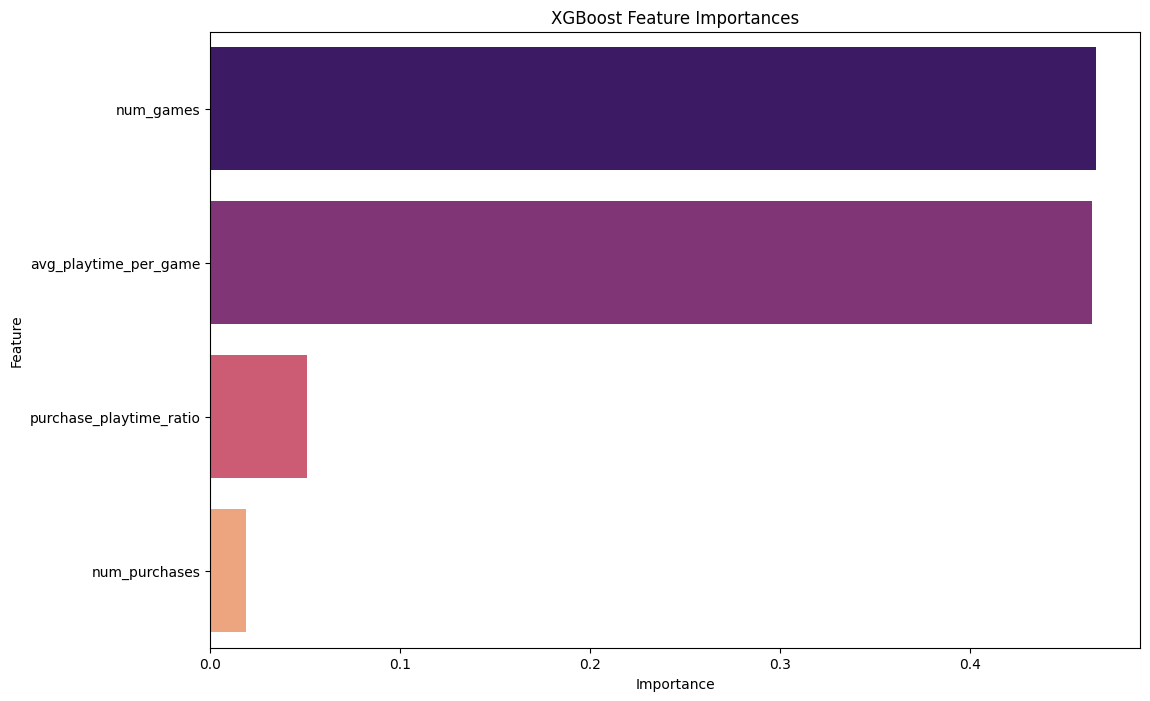

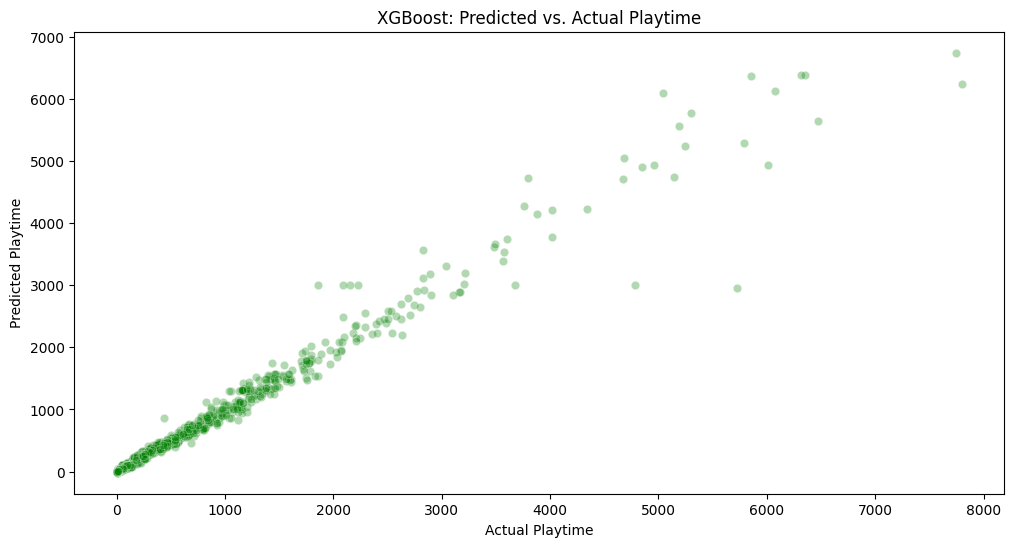

In [25]:
# Define the model
xgb_model = XGBRegressor(random_state=42)

# Hyperparameter tuning with grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kf, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate the best model
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation with fold tracking
cv_scores_xgb = []
for fold, (train_idx, val_idx) in enumerate(kf.split(features, target)):
    print(f"Processing fold {fold + 1}/{kf.get_n_splits()} for XGBoost...")
    best_xgb_model.fit(features.iloc[train_idx], target.iloc[train_idx])
    score = best_xgb_model.score(features.iloc[val_idx], target.iloc[val_idx])
    cv_scores_xgb.append(score)
    print(f"Fold {fold + 1} score: {score}")

print(f"XGBoost Cross-validation scores: {cv_scores_xgb}")
print(f"XGBoost Mean CV score: {np.mean(cv_scores_xgb)}")

# Train the final model on the entire training set
best_xgb_model.fit(X_train, y_train)

# Save the XGBoost model
joblib.dump(best_xgb_model, 'xgboost_model.joblib')

# Make predictions with the best model
y_pred_xgb = best_xgb_model.predict(X_test)

# Feature importances
xgb_importances = best_xgb_model.feature_importances_
feature_importances_xgb = pd.DataFrame({'feature': features.columns, 'importance': xgb_importances})
feature_importances_xgb = feature_importances_xgb.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_xgb, palette='magma')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Predicted vs. actual playtime
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3, color='green')
plt.title('XGBoost: Predicted vs. Actual Playtime')
plt.xlabel('Actual Playtime')
plt.ylabel('Predicted Playtime')
plt.show()

XGBoost proves to be a slightly better model with closer alignment between predicted and actual playtimes and in predicting extreme values.

### 8. Model Comparison & Evaluation

Linear Regression Mean CV score: 0.5419646410800399
Random Forest Mean CV score: 0.9635419035439579
XGBoost Mean CV score: 0.9749206682369664
Model Performance Comparison:
Linear Regression: Mean CV score = 0.5420
Random Forest: Mean CV score = 0.9635
XGBoost: Mean CV score = 0.9749


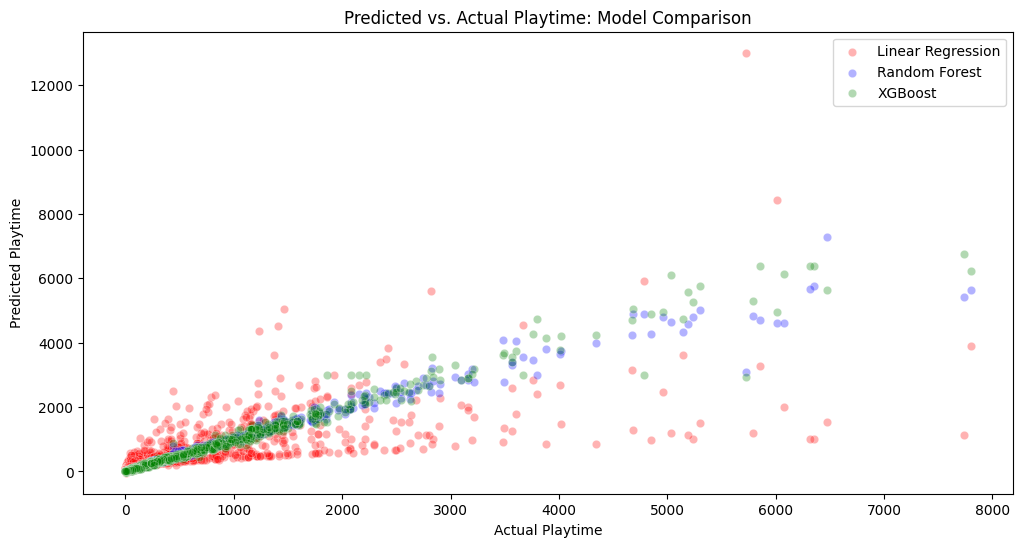

In [28]:
#compare cross-validation scores
print(f"Linear Regression Mean CV score: {np.mean(cv_scores_lr)}")
print(f"Random Forest Mean CV score: {np.mean(cv_scores_rf)}")
print(f"XGBoost Mean CV score: {np.mean(cv_scores_xgb)}")

#comparison summary
print("Model Performance Comparison:")
print(f"Linear Regression: Mean CV score = {np.mean(cv_scores_lr):.4f}")
print(f"Random Forest: Mean CV score = {np.mean(cv_scores_rf):.4f}")
print(f"XGBoost: Mean CV score = {np.mean(cv_scores_xgb):.4f}")

#plot all predicted vs actual playtime in a single plot
plt.figure(figsize=(12, 6))

#linear Regression
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.3, color='red', label='Linear Regression')

#random forest
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3, color='blue', label='Random Forest')

#xgboost
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3, color='green', label='XGBoost')

plt.title('Predicted vs. Actual Playtime: Model Comparison')
plt.xlabel('Actual Playtime')
plt.ylabel('Predicted Playtime')
plt.legend()
plt.show()

- XGBoost outperforms both Linear Regression and Random Forest, especially in predicting higher playtime values accurately.
- While Random Forest provides good predictions, XGBoost's ability to handle complex data relationships results in better overall performance.
- The enhanced accuracy of XGBoost highlights its effectiveness in leveraging the provided features to predict total playtime.

Overall, XGBoost is the preferred model for predicting total playtime.